# Learned Reconstruction

In inverse problems, we want to recover some signal $x$ from noisy measurements $y$ where we know the forward model $\mathcal{T} : \mathcal{X} \to \mathcal{Y}$
$$
    y = \mathcal{T}(x) + e
$$
In machine learning for inverse problems we aim to find some operator $\mathcal{T}_\theta^\dagger : \mathcal{Y} \to \mathcal{X}$ that inverts this process
$$
    \mathcal{T}_\theta^\dagger(y) \approx x
$$

This notebook demonstrates how to use ODL to perform learned reconstruction of the famous MNIST dataset. We demonstrate three ways of doing this

* Fully learned reconstruction
* Learned post-processing
* Learned iterative reconstruction

and we also compare to classical reconstruction methods:

* FBP-based reconstruction
* TV-regularized reconstruction

the results should be approximately

| Method                 |  Mean Error  |
|:-----------------------|:--------:|
| FBP                    | 0.152    |
| Fully learned          | 0.025    |
| FBP + learned denoiser | 0.016    |
| Learned Iterative      | 0.012    |

But the best achieved result on this dataset is a mean error of ~0.005, using a primal-dual learned iterative scheme.

**Note:** The examples in this notebook may take some time to run, approximately 10 minutes each can be expected on a reasonable laptop.

**Note:** In this notebook we'll be training several networks. This is *not* best practice, and typically one only trains one network for each notebook. This is because the more networks we add, the bigger the graph becomes. To properly deal with this we use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) and only initialize a subset of all variables at each point. There is no need to perfectly understand these implementation details as of now.

# Import dependencies

This should run without errors if all dependencies are installed properly.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import odl
from odl.contrib.tensorflow import as_tensorflow_layer
from tensorflow.keras.datasets.mnist import load_data
from IPython.display import display, clear_output

In [2]:
# Start a tensorflow session
session = tf.InteractiveSession()

# Set the random seed to enable reproducible code
np.random.seed(42)
tf.set_random_seed(42)

# Create operators using ODL

Here we create the needed operators in ODL as usual

In [3]:
# Create ODL data structures
space = odl.uniform_discr([-14, -14], [14, 14], [28, 28],
                          dtype='float32')

geometry = odl.tomo.parallel_beam_geometry(space, num_angles=5)
operator = odl.tomo.RayTransform(space, geometry, impl='skimage')

# Get data and utilities

We now need to get the data we will use, which in this case is the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, a set of digits 65000 hand-written digits, of which 55000 are used for training and 10000 for testing.

In addition to this, we create a utility `generate_data` which generates sinograms for each digit, as well as a function `evaluate(...)` that we will use to evaluate how good a reconstruction is and `visualize(...)` which shows an example reconstruction.

In [4]:
# Get MNIST data
(x_train, labels_train), (x_test, labels_test) = load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [5]:
def generate_data(images):
    """Generate data from images
    
    Parameters
    ----------
    images : np.array of shape [Batch, 28, 28, 1]
        The images (in reconstruction space) which we should create data for.
        
    Returns
    -------
    sinograms : np.array of shape [Batch, 5, 41, 1]
        Noisy sinograms corresponding to ``images``
    """
    data = [operator(image.squeeze()).asarray() +
            np.random.randn(*operator.range.shape) for image in images]
    return np.array(data)[..., None]

# Evaluation

We also define a evaluation function, in this setting a reasonable choice of loss function is the expected mean square error

$$
L(\theta) = \mathbb{E}_{x, y} \big\| \mathcal{T}_\theta^\dagger(y) - x \big\|_{\mathcal{X}}^2
$$

As was done in the last exercise, we'll have two separate sets of data, one for training and one for evaluation.

In [6]:
# Read the first 100 mnist test points
test_images = x_test[:100].reshape([-1, 28, 28, 1])

# Create test data (persistent to save time)
test_data = generate_data(test_images)

def evaluate(result_tensor, data_placeholder):
    """Evaluate a reconstruction method.

    Parameters
    ----------
    result_tensor : `tf.Tensor`, shape (None, 28, 28, 1)
        The tensorflow tensor containing the result of the reonstruction
        operator.
    data_placeholder : `tf.Tensor`, shape (None, 5, 41, 1)
        The tensorflow tensor containing the input to the reconstruction
        operator.

    Returns
    -------
    MSE : float
        Mean squared error of the reconstruction.
    """
    result = result_tensor.eval(
        feed_dict={data_placeholder: test_data})

    return np.mean((result - test_images) ** 2)

# Visualization

Since the result is a reconstruction, a visual interpretation is important. We create a helper function that allows us to visualize the result of the reconstruction and to compare several reconstruction operators.

We also create a utility `display_progress` that shows us how the error is decreasing over time.

**Note:** The exact details here are not especially important for understanding the material.

In [7]:
def display_progress(i, max_iter, result_tensor, data_placeholder, every=200):
    """Utility function to display training progress."""
    if (i + 1) % every == 0:
        error = evaluate(result_tensor, data_placeholder)
        clear_output()
        display('{}/{} Error: {:.5f}'.format(i + 1, max_iter, error))

def get_tensor_name(tensor, default_name="Truth"):
    """Utility function to get the name of a tensor."""
    try:
        return tensor.name.split('/')[0]
    except AttributeError:
        return default_name

    
def visualize(result_tensors, data_placeholder, nshow=20):
    """Visualize the result of a reconstruction.
    
    Parameters
    ----------
    result_tensors : list of `tf.Tensor`, shape (None, 28, 28, 1)
        The tensorflow tensor containing the result of the reconstruction
        operator.
    data_placeholder : `tf.Tensor`, shape (None, 5, 41, 1)
        The tensorflow tensor containing the input to the reconstruction
        operator.
    nshow : `int`
        Number of images to show.
    """        
    indices = np.arange(nshow)
    results = [result_tensor.eval(feed_dict={data_placeholder: test_data[indices]}) 
               for result_tensor in result_tensors]
    
    results_ = [test_images[indices]] + results
    names = [get_tensor_name(tensor) 
             for tensor in [None]+result_tensors]
    
    figsize = 2
    fig, rows = plt.subplots(len(indices), len(results_), sharex=True, sharey=True, figsize=(len(results_)*figsize, figsize*len(indices)))
    # stupid matplotlib:
    if len(indices) == 1:
        rows = [rows]
    for i, row in enumerate(rows):
        for name, res, ax in zip(names, results_, row):
            if i == 0:
                ax.set_title(name)
            ax.imshow(res[i].squeeze(), clim=[0,1], cmap="bone")
            ax.set_axis_off()
    plt.show()

### Placeholders

Create placeholders. Placeholders are needed in tensorflow since tensorflow is a lazy language,
and hence we first define the computational graph with placeholders as input, and later we evaluate it.


In [8]:
with tf.name_scope('placeholders'):
    x_true = tf.placeholder(tf.float32, shape=[None, *operator.domain.shape, 1], name="x_true")
    y = tf.placeholder(tf.float32, shape=[None, *operator.range.shape, 1], name="y")

# Filtered back-projection


Here we first create a filtered back-projection operator using [`odl.tomo.fbp_op`](https://odlgroup.github.io/odl/generated/odl.tomo.analytic.filtered_back_projection.fbp_op.html) and convert it into a tensorflow layer using `odl.contrib.tensorflow.as_tensorflow_layer`. This allows us to use the FBP operator as part of a neural network.

In [9]:
fbp_op = odl.tomo.fbp_op(operator)
tf_fbp_op = as_tensorflow_layer(fbp_op, name="FBP")

In [10]:
print('FBP Mean squared error: {}'.format(evaluate(tf_fbp_op(y), y)))


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
FBP Mean squared error: 0.19349731047259502


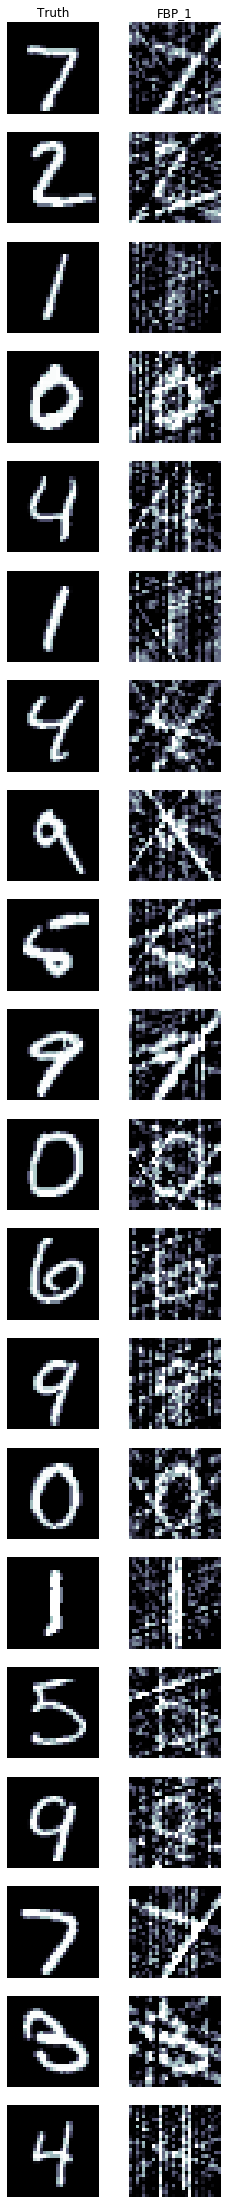

In [11]:
visualize([tf_fbp_op(y)], y)

# Fully Learned Reconstruction

The most straight-forward example of a learned reconstruction method is the fully-learned reconstruction. In this method, we use a fully-connected neural network to map data to reconstruction, using no information about the forward operator.

In this example, we use a network of the form

$$
\mathcal{T}_\theta^\dagger(y) = \Lambda_{\theta}(y)
$$

where $\Lambda_{\theta}$ is a MLP with two hidden layers, each with 1024 neurons. See [part 2](part2_classification.ipynb) for details.

In [12]:
with tf.variable_scope(None, default_name='flr'):  # use a variable scope to allow us to re-tune parameters
    x = tf.contrib.layers.flatten(y)

    x = tf.contrib.layers.fully_connected(x, num_outputs=1024)
    x = tf.contrib.layers.fully_connected(x, num_outputs=1024)
    x = tf.contrib.layers.fully_connected(x, num_outputs=28 * 28,
                                          activation_fn=None)

    x_result_fully = tf.reshape(x, [-1, 28, 28, 1])

    with tf.name_scope('optimizer'):
        loss = tf.reduce_mean((x_result_fully - x_true) ** 2)
        optimizer = tf.train.AdamOptimizer().minimize(loss)
        
# Initialize current variables
session.run([v.initializer for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='flr')]);

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
max_iter = 10000
bs = 5
for i in range(max_iter):
    j = i % len(x_train)
    batch = x_train[j*bs:(j+1)*bs]
    images = batch.reshape([-1, 28, 28, 1])
    data = generate_data(images)

    session.run(optimizer, feed_dict={x_true: images, y: data})
    
    display_progress(i, max_iter, x_result_fully, y)

'10000/10000 Error: 0.02484'

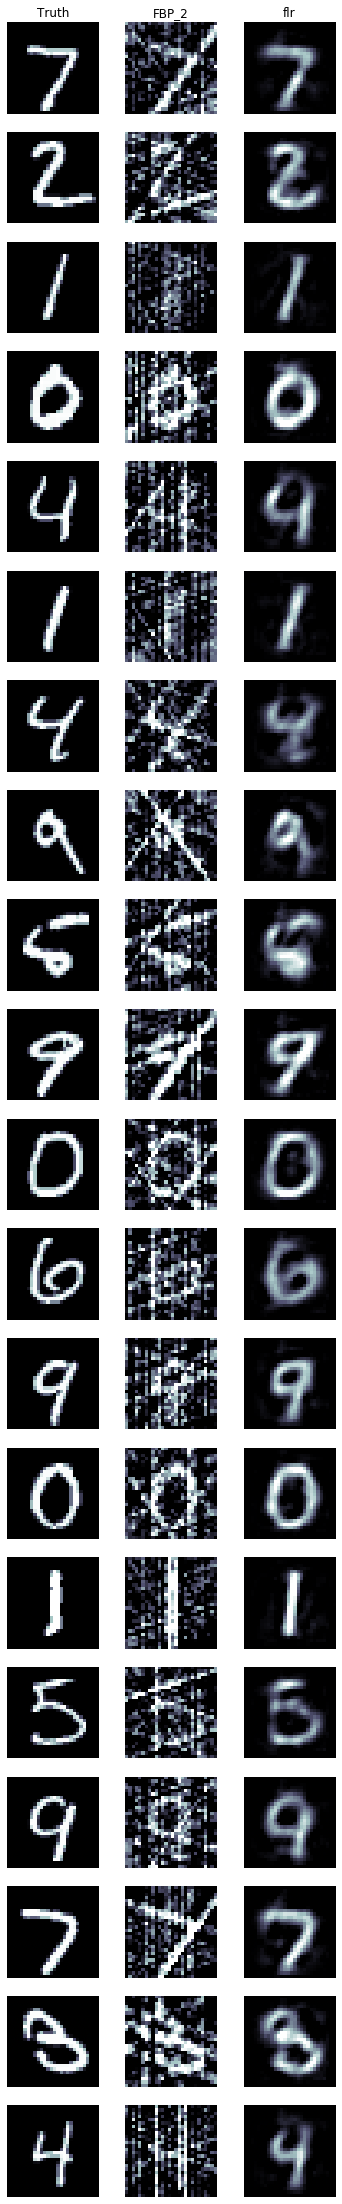

In [14]:
visualize([tf_fbp_op(y), x_result_fully], y)

# FBP + Learned denoiser

A more efficient method is to first compute some initial reconstruction (here, a filtered back-projection) and then learn how to improve that reconstruction. By doing this, we only need to learn in image space and can thus use very strong tools from machine learning, including convolutional neural networks.

In this example, we use a [residual network](part2_exercises.ipynb#Exercise-1:-Residual-networks) of the form

$$
x_0 = \mathcal{T}^\dagger(y)
\\
x_{i+1} = x_i + \Lambda_{\theta_i}(x_i)
\\
\mathcal{T}_\theta^\dagger(y) = x_I
$$

where $\Lambda_{\theta_i}$ is a convolutional neural network.

In [15]:
with tf.variable_scope(None, default_name='denoise'):
    current = tf_fbp_op(y)

    for i in range(2):
        dx = tf.contrib.layers.conv2d(current, num_outputs=32, kernel_size=3)
        dx = tf.contrib.layers.conv2d(dx, num_outputs=32, kernel_size=3)
        dx = tf.contrib.layers.conv2d(dx, num_outputs=1, kernel_size=1,
                                      activation_fn=None)

        current = current + dx

    x_result_denoise = current

    with tf.name_scope('optimizer'):
        loss = tf.reduce_mean((x_result_denoise - x_true) ** 2)
        optimizer = tf.train.AdamOptimizer(beta2=0.99).minimize(loss)  # different beta2 for faster convergence

# Initialize all denoising variables
session.run([v.initializer for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='denoise')]);

In [16]:
bs = 5
for i in range(max_iter):
    j = i % len(x_train)
    batch = x_train[j*bs:(j+1)*bs]
    images = batch.reshape([-1, 28, 28, 1])
    data = generate_data(images)

    session.run(optimizer, feed_dict={x_true: images, y: data})

    display_progress(i, max_iter, x_result_denoise, y)

'10000/10000 Error: 0.01855'

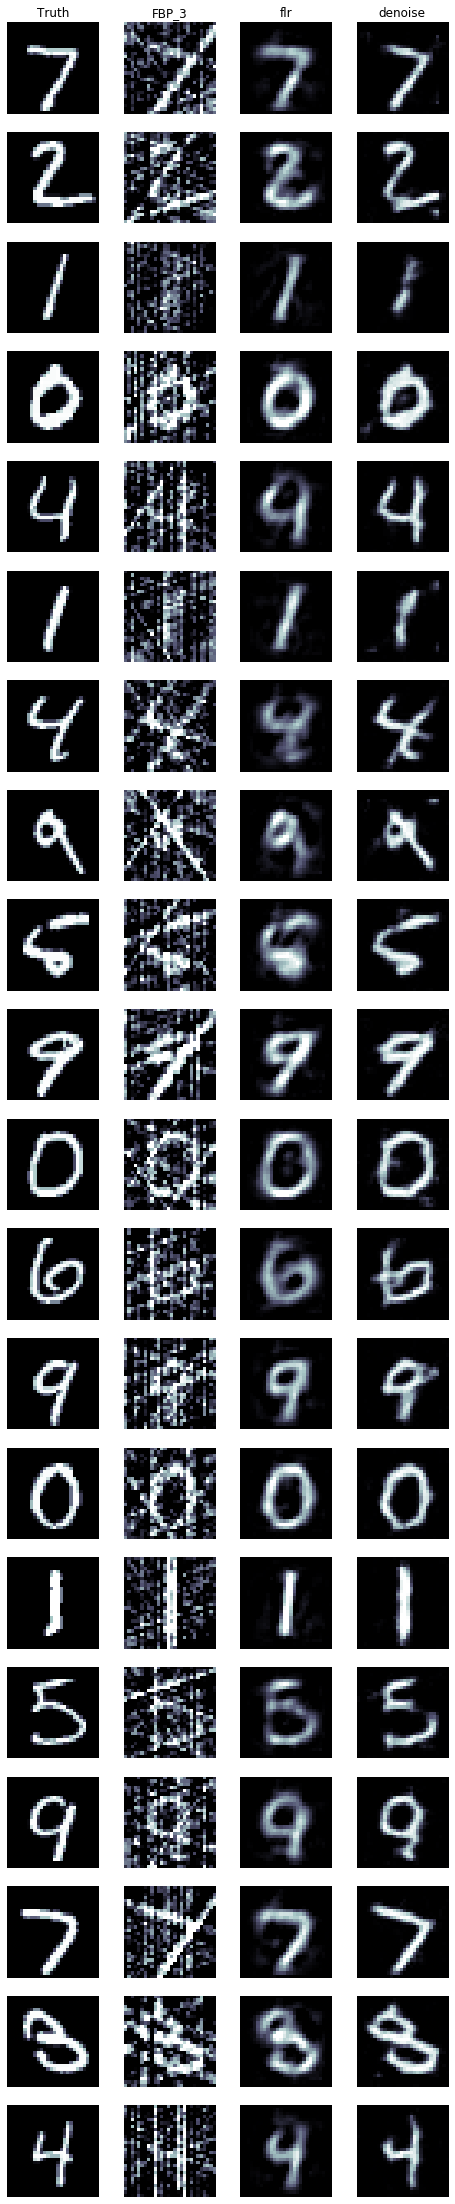

In [17]:
visualize([tf_fbp_op(y), x_result_fully, x_result_denoise], y)

# Learned Iterative reconstruction

In Learned iterative reconstruction, we embed the forward operator into a neural network and use it as a component in the neural network. By doing so, we never loose connection to the data during the reconstruction.

In this example, we use a so called (partially) Learned Gradient network of the form:

$$
x_0 = \mathcal{T}^\dagger(y)
\\
x_{i+1} = x_i + \Lambda_{\theta_i}(x_i, \mathcal{T}^*(\mathcal{T}(x_i) - y))
\\
\mathcal{T}_\theta^\dagger(y) = x_I
$$

Note that this is basically equivalent to the denoising network above, except we include the forward operator in each iteration.

In [18]:
# Create tensorflow wrappers
tf_op = as_tensorflow_layer(operator)
tf_op_adj = as_tensorflow_layer(operator.adjoint)

In [19]:
with tf.variable_scope(None, default_name='learned_iterative'):
    current = tf_fbp_op(y)

    for i in range(2):
        gradient = tf_op_adj(tf_op(current) - y)

        dx = tf.concat([current, gradient], axis=-1)
        dx = tf.contrib.layers.conv2d(dx, num_outputs=32, kernel_size=3)
        dx = tf.contrib.layers.conv2d(dx, num_outputs=32, kernel_size=3)
        dx = tf.contrib.layers.conv2d(dx, num_outputs=1, kernel_size=1,
                                      activation_fn=None)
        current = current + dx

    x_result_li = current

    with tf.name_scope('optimizer'):
        loss = tf.reduce_mean((x_result_li - x_true) ** 2)
        optimizer = tf.train.AdamOptimizer(beta2=0.99).minimize(loss)  # different beta2 for faster convergence

# Initialize all current variables
session.run([v.initializer for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='learned_iterative')]);

In [20]:
max_iter = 10000
bs = 5
for i in range(max_iter):
    j = i % len(x_train)
    batch = x_train[j*bs:(j+1)*bs]
    images = batch.reshape([-1, 28, 28, 1])
    data = generate_data(images)

    session.run(optimizer, feed_dict={x_true: images, y: data})

    display_progress(i, max_iter, x_result_li, y)

'10000/10000 Error: 0.01217'

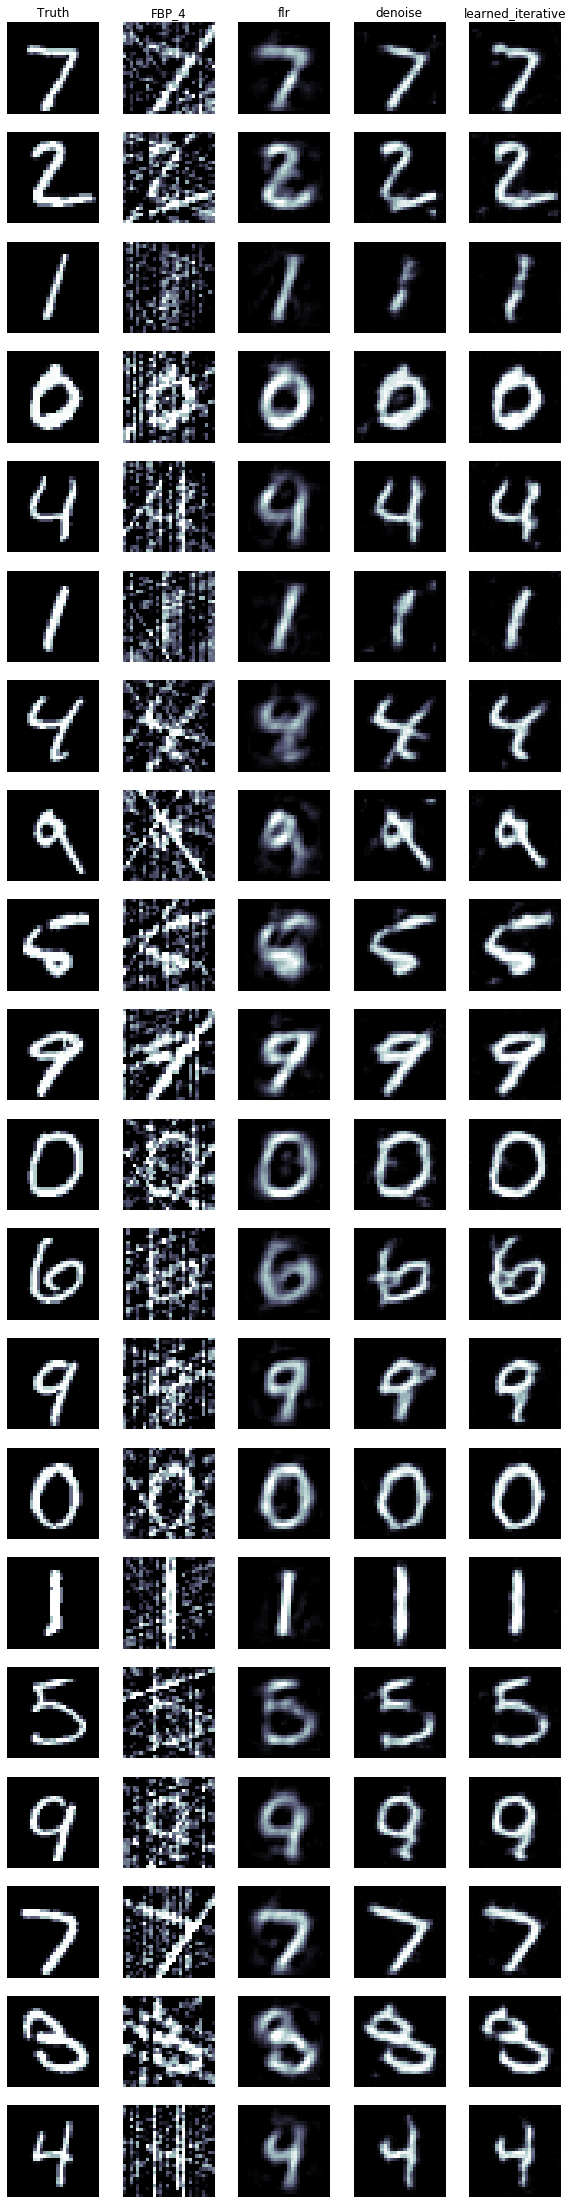

In [21]:
visualize([tf_fbp_op(y), x_result_fully, x_result_denoise, x_result_li], y)

# Learned PDHG

The algorithm accounts for a forward operator in a deep neural network by unrolling a proximal primal-dual optimization method, but where the proximal operators have been replaced with convolutional neural networks. 

In this example, we use a network of the form:

$$
x_0 = 0
\\
h_0 = 0
\\
h_{i+1} = \Gamma_{\theta^d}(h_i+\sigma \mathcal{T}(\bar{x}_i), y)
\\
x_{i+1} = \Lambda_{\theta^p}(x_i - \tau [\partial \mathcal{T}(x_i)]^*(h_{i+1}))
\\
\bar{x}_{i+1} = x_{i+1} + \theta(x_{i+1}-x_i)
\\
\mathcal{T}_{\Theta}^\dagger(y) = x_I
$$

In [22]:
# Create tensorflow wrappers
tf_op = as_tensorflow_layer(operator)
tf_op_adj = as_tensorflow_layer(operator.adjoint)
op_norm = 1.1 * odl.power_method_opnorm(operator)

In [23]:
with tf.variable_scope(None, default_name='learned_pdhg'):
    def network1_pdhg(h, y):
        dh = tf.concat([h, y], axis=-1)
        dh = tf.contrib.layers.conv2d(dh, num_outputs=32, kernel_size=3)
        dh = tf.contrib.layers.conv2d(dh, num_outputs=32, kernel_size=3)
        dh = tf.contrib.layers.conv2d(dh, num_outputs=1, kernel_size=1, activation_fn=None)
        return h + dh

    def network2_pdhg(x):
        dx = tf.contrib.layers.conv2d(x, num_outputs=32, kernel_size=3)
        dx = tf.contrib.layers.conv2d(dx, num_outputs=32, kernel_size=3)
        dx = tf.contrib.layers.conv2d(dx, num_outputs=1, kernel_size=1, activation_fn=None)
        return x + dx

    tau = tf.Variable(1/op_norm, name='tau', dtype = tf.float32)
    sigma = tf.Variable(1/op_norm, name='sigma', dtype = tf.float32)
    theta = tf.Variable(1, name='theta', dtype = tf.float32)

    h = tf.zeros_like(y)
    x = tf.zeros_like(tf_fbp_op(y))
    x_bar = tf.zeros_like(x)

    for i in range(2):
        h = h + sigma * tf_op(x_bar)
        h = network1_pdhg(h, y)
        x_prev = x
        x = x - tau * tf_op_adj(h)
        x = network2_pdhg(x)
        x_bar = x + theta * (x - x_prev)
    x_result_lpdhg = x

    with tf.name_scope('optimizer'):
        loss = tf.reduce_mean((x_result_lpdhg - x_true) ** 2)
        optimizer = tf.train.AdamOptimizer(beta2=0.99).minimize(loss)  # different beta2 for faster convergence

# Initialize all current variables
session.run([v.initializer for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='learned_pdhg')]);

In [24]:
max_iter = 10000
bs = 5
for i in range(max_iter):
    j = i % len(x_train)
    batch = x_train[j*bs:(j+1)*bs]
    images = batch.reshape([-1, 28, 28, 1])
    data = generate_data(images)
    session.run(optimizer, feed_dict={x_true: images, y: data})

    display_progress(i, max_iter, x_result_lpdhg, y)

'10000/10000 Error: 0.01007'

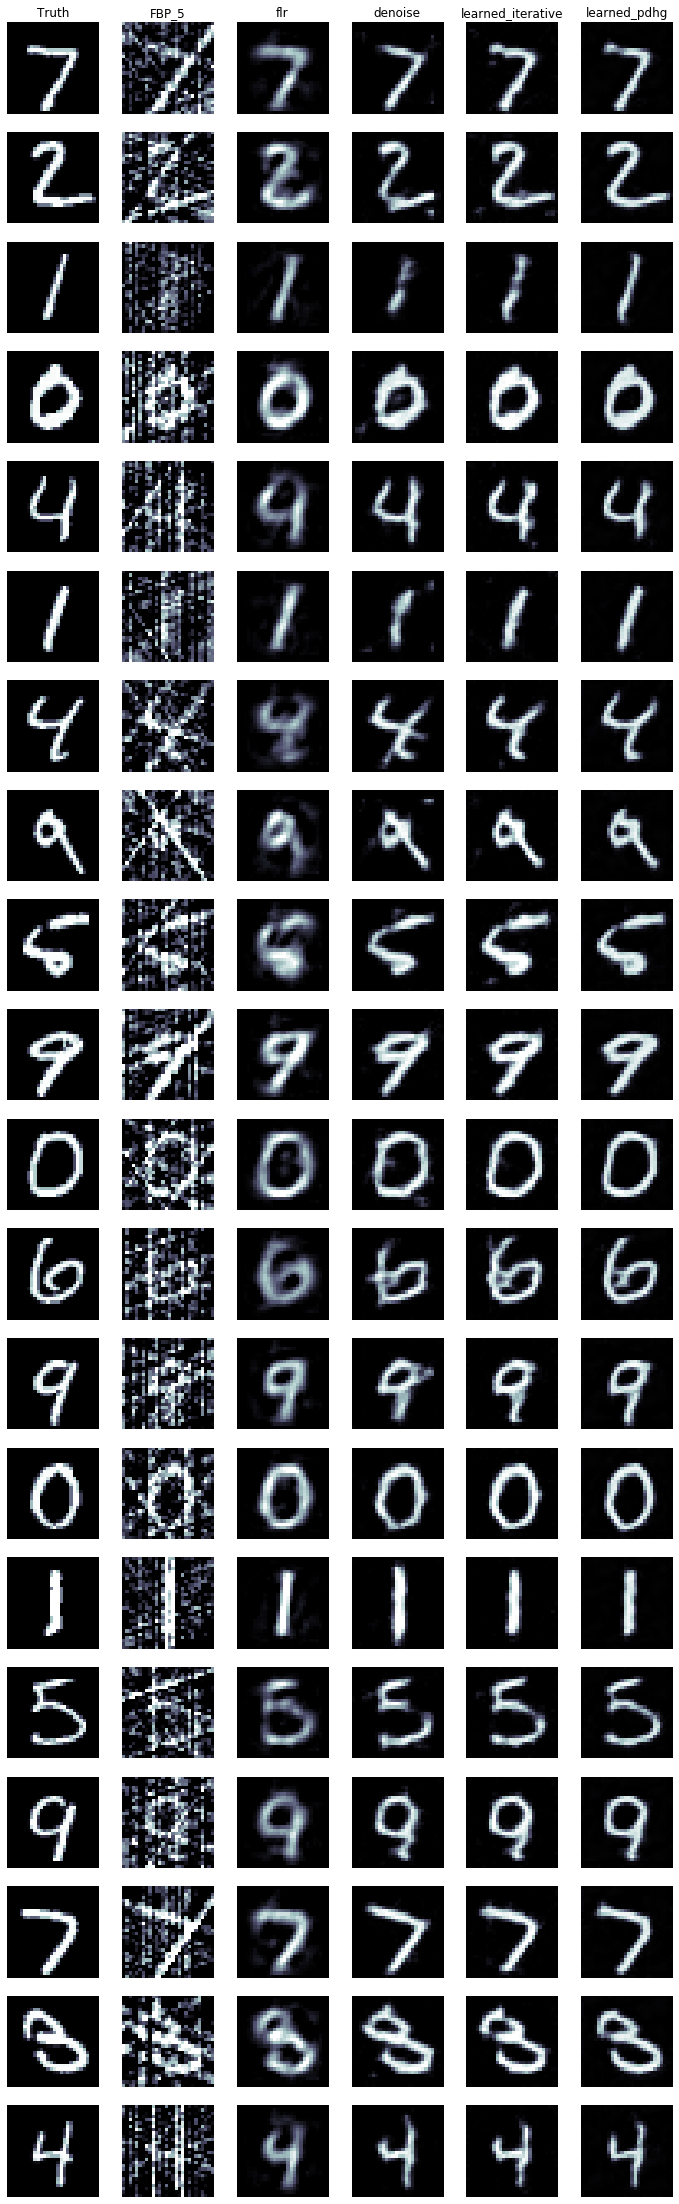

In [25]:
visualize([tf_fbp_op(y), x_result_fully, x_result_denoise, x_result_li, x_result_lpdhg], y)

# Conclusions

In this notebook we have learned several ways in which we can learn to solve inverse problems, starting from fully learned, to learning a post-processing to hybrid learned iterative schemes. We applied this to the famous MNIST data-set, but the theories should generalize by simply changing the forward operator (and possibly the pseudo-inverse).

After having read this notebook you should:

* Know the general outlines of machine learning for inverse problems, in particular you should know about
  * Fully learned methods, and why they are bad
  * Learned post-processing
  * Learned iterative schemes
* You should also know how to implement these methods for other problems